In [ ]:
#!pip install torch --upgrade
import os
import pathlib
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
from torch.nn.functional import one_hot
from collections import defaultdict
print(torch.__version__)
#Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
!nvcc --version

2.0.1+cu118
cuda
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
import zipfile
from pathlib import Path

#Setup path to a data folder
data_path = Path("gene_data/")
text_path = data_path / "RMS_genes"

if text_path.is_dir():
  print(f"{text_path} directory already exists.. skipping extraction")
else:
  print(f"{text_path} does not exist, creating one...")
  text_path.mkdir(parents=True, exist_ok=True)

# File path in Google Colab after upload
zip_path = Path("gene_data/RMS_genes/110k_set.zip")  # Update this if your file is in a different location

#Unzip the data
with zipfile.ZipFile(zip_path, "r") as zip_ref:
  print(f"Unzipping file...")
  zip_ref.extractall(text_path)


gene_data/RMS_genes directory already exists.. skipping extraction
Unzipping file...


In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} sequences in '{dirpath}'.")

walk_through_dir(text_path)

There are 2 directories and 1 sequences in 'gene_data/RMS_genes'.
There are 3 directories and 0 sequences in 'gene_data/RMS_genes/110k_set'.
There are 13 directories and 0 sequences in 'gene_data/RMS_genes/110k_set/test'.
There are 0 directories and 100 sequences in 'gene_data/RMS_genes/110k_set/test/Type_III_restriction_enzyme'.
There are 0 directories and 100 sequences in 'gene_data/RMS_genes/110k_set/test/negative'.
There are 0 directories and 100 sequences in 'gene_data/RMS_genes/110k_set/test/Type_II_restriction_enzyme'.
There are 0 directories and 100 sequences in 'gene_data/RMS_genes/110k_set/test/Type_II_methyltransferase'.
There are 0 directories and 100 sequences in 'gene_data/RMS_genes/110k_set/test/Type_III_methyltransferase'.
There are 0 directories and 100 sequences in 'gene_data/RMS_genes/110k_set/test/Type_IIG_restriction_enzyme_methyltransferase'.
There are 0 directories and 0 sequences in 'gene_data/RMS_genes/110k_set/test/.ipynb_checkpoints'.
There are 0 directories 

In [ ]:
#Setup train and testing paths
train_dir = text_path / "110k_set" / "train"
val_dir = text_path / "110k_set" / "val"
test_dir = text_path / "110k_set" / "test"
train_dir, val_dir, test_dir

(PosixPath('gene_data/RMS_genes/110k_set/train'),
 PosixPath('gene_data/RMS_genes/110k_set/val'),
 PosixPath('gene_data/RMS_genes/110k_set/test'))

In [ ]:
from torch.nn.functional import one_hot
from torch.utils.data import Dataset
import os
import torch
from collections import defaultdict

# Define a index encoding for the amino acid sequences
amino_acids = ['A', 'C', 'D', 'E', 'F',
               'G', 'H', 'I', 'K', 'L',
               'M', 'N', 'P', 'Q', 'R',
               'S', 'T', 'V', 'W', 'Y', '0']
amino_to_index = {aa: index for index, aa in enumerate(amino_acids)}

class AminoAcidSequenceDataset(Dataset):
    def __init__(self, root_dir, classes):
        self.classes = classes # get list of classes
        # Create a mapping of class names to integers
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.files = []
        self.labels = []
        self.max_length = 0

        # loop through each class's directory, then each file in that directory
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                self.files.append(file_path)
                # Use the mapping to convert class names to integers
                self.labels.append(self.class_to_idx[class_name])

                # open the file and find its length
                with open(file_path, 'r') as f:
                    sequence = f.read().strip()
                    self.max_length = max(self.max_length, len(sequence))

        # Print the lengths of self.files and self.labels
        print(f"Length of self.files: {len(self.files)}")
        print(f"Length of self.labels: {len(self.labels)}")

    def __len__(self):
      return len(self.files)

    def __getitem__(self, idx):
        with open(self.files[idx], 'r') as f:
            sequence = f.read().strip()

        sequence = sequence.ljust(2000, '0')

        amino_to_index_default = defaultdict(lambda: amino_to_index['0'])
        amino_to_index_default.update(amino_to_index)
        index_sequence = [amino_to_index_default[aa] for aa in sequence]

        # Convert indices to one-hot encoded tensor
        sequence_tensor = torch.nn.functional.one_hot(torch.tensor(index_sequence, dtype=torch.long),
                                                      num_classes=len(amino_to_index))

        return sequence_tensor.float().to(device), self.labels[idx]

# Specify the order of classes
classes = ['Type_III_restriction_enzyme',
           'Type_II_restriction_enzyme',
           'Type_II_methyltransferase',
           'Type_III_methyltransferase',
           'Type_IIG_restriction_enzyme_methyltransferase',
           'Type_IV_methyl-directed_restriction_enzyme',
           'Type_II_specificity_subunit',
           'Type_I_restriction_enzyme',
           'Type_I_specificity_subunit',
           'negative',
           'Type_I_methyltransferase']

# Create your datasets
train_data = AminoAcidSequenceDataset(root_dir=train_dir, classes=classes)
val_data = AminoAcidSequenceDataset(root_dir=val_dir, classes=classes)
test_data = AminoAcidSequenceDataset(root_dir=test_dir, classes=classes)

# Get the first item in the dataset
first_item, first_label = train_data[0]

# Print its shape
print(first_item.shape)


Length of self.files: 99000
Length of self.labels: 99000
Length of self.files: 9900
Length of self.labels: 9900
Length of self.files: 1100
Length of self.labels: 1100
torch.Size([2000, 21])


In [ ]:
# Randomly select a file
random_index = random.choice(range(len(train_data.files)))
random_file_path = train_data.files[random_index]

# Get the associated file name and class
random_file_class = train_data.labels[random_index]
random_file_name = os.path.basename(random_file_path)
# Open and read the file
with open(random_file_path, 'r') as file:
    print(f"File: {random_file_name}\n\nFile content:\n{file.read()}")

# Print the associated class
print(f"\nAssociated class: {random_file_class}")


File: PBEDAPHE_00532_GDP-perosamine_N-acetyltransferase.txt

File content:
MHDLVIIGCGGFGRESADVVDAINRSAPTWNLLGFVDDDPSAENVARVRRRGAALLGGLEAFSSRGRGVHYAIGIGDAPTRERVASVAEAAGMVPATLVHPWAAIGADADIGEGVVVCAYAQIGSDVSIGRHVHLDRASQIGHDCAVEDFVTVHPAAVVSGGCVLGPGAELGTGSTILPGTAVGAHAVVGAAACVVKDVPPGVTVKGVPAG

Associated class: 9


In [ ]:
#Get class names as a list
#Check the lengths of our dataset
print(len(train_data), len(val_data), len(test_data))
class_dict = train_data.class_to_idx
class_dict

99000 9900 1100


{'Type_III_restriction_enzyme': 0,
 'Type_II_restriction_enzyme': 1,
 'Type_II_methyltransferase': 2,
 'Type_III_methyltransferase': 3,
 'Type_IIG_restriction_enzyme_methyltransferase': 4,
 'Type_IV_methyl-directed_restriction_enzyme': 5,
 'Type_II_specificity_subunit': 6,
 'Type_I_restriction_enzyme': 7,
 'Type_I_specificity_subunit': 8,
 'negative': 9,
 'Type_I_methyltransferase': 10}

In [ ]:
print(train_data.class_to_idx)
print(val_data.class_to_idx)
print(test_data.class_to_idx)

{'Type_III_restriction_enzyme': 0, 'Type_II_restriction_enzyme': 1, 'Type_II_methyltransferase': 2, 'Type_III_methyltransferase': 3, 'Type_IIG_restriction_enzyme_methyltransferase': 4, 'Type_IV_methyl-directed_restriction_enzyme': 5, 'Type_II_specificity_subunit': 6, 'Type_I_restriction_enzyme': 7, 'Type_I_specificity_subunit': 8, 'negative': 9, 'Type_I_methyltransferase': 10}
{'Type_III_restriction_enzyme': 0, 'Type_II_restriction_enzyme': 1, 'Type_II_methyltransferase': 2, 'Type_III_methyltransferase': 3, 'Type_IIG_restriction_enzyme_methyltransferase': 4, 'Type_IV_methyl-directed_restriction_enzyme': 5, 'Type_II_specificity_subunit': 6, 'Type_I_restriction_enzyme': 7, 'Type_I_specificity_subunit': 8, 'negative': 9, 'Type_I_methyltransferase': 10}
{'Type_III_restriction_enzyme': 0, 'Type_II_restriction_enzyme': 1, 'Type_II_methyltransferase': 2, 'Type_III_methyltransferase': 3, 'Type_IIG_restriction_enzyme_methyltransferase': 4, 'Type_IV_methyl-directed_restriction_enzyme': 5, 'Type_

In [ ]:
from collections import Counter

# Print class_to_idx for each dataset
print("train_data.class_to_idx: ", train_data.class_to_idx)
print("val_data.class_to_idx: ", val_data.class_to_idx)
print("test_data.class_to_idx: ", test_data.class_to_idx)

# Function to count samples for each class in a dataset
def print_class_counts(data, name):
    label_counts = Counter(data.labels)  # Assumes your dataset object stores labels in 'targets'. If not, adjust as necessary.
    print("\n" + name + " class counts:")
    for class_name, idx in data.class_to_idx.items():
        print(f"{class_name}: {label_counts[idx]} samples")

# Print class counts for each dataset
print_class_counts(train_data, "Train Data")
print_class_counts(val_data, "Validation Data")
print_class_counts(test_data, "Test Data")


train_data.class_to_idx:  {'Type_III_restriction_enzyme': 0, 'Type_II_restriction_enzyme': 1, 'Type_II_methyltransferase': 2, 'Type_III_methyltransferase': 3, 'Type_IIG_restriction_enzyme_methyltransferase': 4, 'Type_IV_methyl-directed_restriction_enzyme': 5, 'Type_II_specificity_subunit': 6, 'Type_I_restriction_enzyme': 7, 'Type_I_specificity_subunit': 8, 'negative': 9, 'Type_I_methyltransferase': 10}
val_data.class_to_idx:  {'Type_III_restriction_enzyme': 0, 'Type_II_restriction_enzyme': 1, 'Type_II_methyltransferase': 2, 'Type_III_methyltransferase': 3, 'Type_IIG_restriction_enzyme_methyltransferase': 4, 'Type_IV_methyl-directed_restriction_enzyme': 5, 'Type_II_specificity_subunit': 6, 'Type_I_restriction_enzyme': 7, 'Type_I_specificity_subunit': 8, 'negative': 9, 'Type_I_methyltransferase': 10}
test_data.class_to_idx:  {'Type_III_restriction_enzyme': 0, 'Type_II_restriction_enzyme': 1, 'Type_II_methyltransferase': 2, 'Type_III_methyltransferase': 3, 'Type_IIG_restriction_enzyme_met

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16000
NUM_WORKERS = 0

print(f"Length of train_data before creating DataLoader: {len(train_data)}")
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

print(f"Length of validation_data before creating DataLoader: {len(val_data)}")
val_dataloader = DataLoader(dataset=val_data,
                                   batch_size=BATCH_SIZE,
                                   num_workers=NUM_WORKERS,
                                   shuffle=False)

print(f"Length of test_data before creating DataLoader: {len(test_data)}")
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, val_dataloader, test_dataloader


Length of train_data before creating DataLoader: 99000
Length of validation_data before creating DataLoader: 9900
Length of test_data before creating DataLoader: 1100


(<torch.utils.data.dataloader.DataLoader at 0x7e85b61d8ac0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e85b61d9c60>)

In [ ]:
seq, label = train_data[0][0], train_data[0][1]

print(f"Image tensor:\n{seq}")
print(f"Image shape: {seq.shape}")
print(f"Image datatype: {seq.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')
Image shape: torch.Size([2000, 21])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


In [ ]:
print(len(train_dataloader), len(test_dataloader))
print(len(train_data), len(test_data))
print()
seq, label = next(iter(train_dataloader))
print(f"Image shape: {seq.shape} -> [batch_size, height, width]")
print(f"Label shape: {label.shape}")

7 1
99000 1100

Image shape: torch.Size([16000, 2000, 21]) -> [batch_size, height, width]
Label shape: torch.Size([16000])


### Model 1 ###

(taken from Deep_CNN_LSTM_Go paper, which this model is based off of)

Difference between model 1 and model 0 is mainly use of validation set in this one

"
*  First stage One Hot-Encoding is the input stage that takes an input of the amino-acid sequences, stacking each amino acid sequence in separate space which located lndex= 1 and the others is zeros. It employs one-hot encoding with a maximum amino-acid sequence input length of 2000 different symbols.

* Second stage 1D-CNN is the convolutional neural network stage. It consists of eight parallel 1D-CNN architectures. These are constructed and built with the following number of filters:

  1. 2000 - 7 = 1993
  2. 1992 - 7 = 1985
  3. 1984 - 7 = 1977
  4. 1976 - 7 = 1969
  5. 1968 - 7 = 1961
  6. 1960 - 7 = 1953
  7. 1952 - 7 = 1945
  8. 1944 - 7 = 1937

  The maximum kernel size (filter length) of 128 per filter is used.

* Third Stage Max-Pooling is composed of eight Max-Pooling units attached to the outputs of the eight 1D-CNN blocks of the second stage. These units are constructed with a window size of 128.

*  Fourth stage LSTM is allocated after each max-pooling unit. An LSTM stage is concatenated with a dimension of output space of size eight. It is activated with a "tanh" activation function.

*  Fifth Stage Flatten All outputs from the LSTM stage are directed as inputs to each one of the eight Flatten blocks forming this stage.

* Sixth stage output takes its inputs from the outputs of the eight blocks of the Flatten stage. It contains neurons activated with the Sigmoid activation function to add non-linearities to the output. The number of the output neurons is equal to the number of required functions of 10.

"

In [ ]:
class RMSI(nn.Module):
    def __init__(self, num_classes=11):
        super(RMSI, self).__init__()

        self.num_classes = num_classes
        self.filters = [21, 21, 21, 21, 21, 21, 21, 21]
        self.kernel_size = 128
        self.pool_size = 128
        self.lstm_out_dim = 8
        self.one_hot_size = 21

        self.cnn_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(self.one_hot_size,
                          out_channels=f,
                          kernel_size=self.kernel_size,
                          stride=1),
                nn.MaxPool1d(self.pool_size)
            ) for f in self.filters
        ])

        self.lstm_layers = nn.ModuleList([nn.LSTM(input_size=f, hidden_size=self.lstm_out_dim) for f in self.filters])

        self.flatten = nn.Flatten()
        self.output_layer = nn.Sequential(
            nn.Linear(self.lstm_out_dim * len(self.filters),
                      self.num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        cnn_outs = [cnn(x) for cnn in self.cnn_layers]
        lstm_outs = [lstm(cnn_out.permute(2, 0, 1))[0][-1, :, :] for lstm, cnn_out in zip(self.lstm_layers, cnn_outs)]  # take output at last timestep only
        concatenated = torch.cat(lstm_outs, dim=1)
        flat_outs = self.flatten(concatenated)
        out = self.output_layer(flat_outs)
        return out


In [ ]:
model_0 = RMSI(num_classes=11)

# assuming you have input data in `inputs`
# and targets in `targets`
inputs = torch.randn(1, 21, 2000)  # batch_size=32, one_hot_size=21, sequence_length=2000
targets = torch.randint(0, 2, (1, 11)).float()  # binary targets for 11 classes for a batch of 32

outputs = model_0(inputs)
loss = nn.BCELoss()(outputs, targets)  # binary cross-entropy loss for multi-label classification



In [ ]:
# Install torchinfo if it's not available, import it if it is
#!pip install torchinfo
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

summary(model_0, input_size=(1, 21, 2000))
# do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
RMSI                                     [1, 11]                   --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 21, 14]               --
│    │    └─Conv1d: 3-1                  [1, 21, 1873]             56,469
│    │    └─MaxPool1d: 3-2               [1, 21, 14]               --
│    └─Sequential: 2-2                   [1, 21, 14]               --
│    │    └─Conv1d: 3-3                  [1, 21, 1873]             56,469
│    │    └─MaxPool1d: 3-4               [1, 21, 14]               --
│    └─Sequential: 2-3                   [1, 21, 14]               --
│    │    └─Conv1d: 3-5                  [1, 21, 1873]             56,469
│    │    └─MaxPool1d: 3-6               [1, 21, 14]               --
│    └─Sequential: 2-4                   [1, 21, 14]               --
│    │    └─Conv1d: 3-7                  [1, 21, 1873]             56,469

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
seq_batch, label_batch = next(iter(train_dataloader))
seq_batch, label_batch = seq_batch.to(device), label_batch.to(device) # moving batch to GPU

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
seq_single, label_single = seq_batch[0].unsqueeze(dim=0), label_batch[0]
seq_single = torch.permute(seq_single, (0, 2, 1))
#seq_single = seq_single.transpose(1, 2)  # This switches the sequence_length and num_channels dimensions
seq_single = seq_single.float().to(device)  # Convert to float tensor before sending it to the device
# Move the label tensor to the device
label_single = label_single.to(device)
print(f"Single image shape: {seq_single.shape}\n")
print(device)
# 3. Perform a forward pass on a single image
model_0 = model_0.to(device)
model_0.eval()
with torch.no_grad():
  pred = model_0(seq_single)

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
probs = torch.softmax(pred, dim=1)
print(f"Output prediction probabilities:\n{probs}\n")
print(f"Output prediction label:\n{torch.argmax(probs, dim=1)}\n")
print(f"Actual label:\n{label_single}")


Single image shape: torch.Size([1, 21, 2000])

cuda
Output logits:
tensor([[0.5504, 0.5156, 0.4720, 0.4889, 0.4849, 0.5142, 0.5238, 0.4770, 0.5234,
         0.4670, 0.5093]], device='cuda:0')

Output prediction probabilities:
tensor([[0.0953, 0.0921, 0.0882, 0.0897, 0.0893, 0.0920, 0.0928, 0.0886, 0.0928,
         0.0877, 0.0915]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
1


In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.float().to(device), y.to(device)
        #Transpose so it fits
        X = X.transpose(1, 2)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def validation_step(model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup validation loss and validation accuracy values
    validation_loss, validation_acc = 0, 0

    # Turn on inference context manager
    with torch.no_grad():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.float().to(device), y.to(device)
            #Transpose so it fits
            X = X.transpose(1, 2)

            # 1. Forward pass
            validation_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(validation_pred_logits, y)
            validation_loss += loss.item()

            # Calculate and accumulate accuracy
            validation_pred_labels = validation_pred_logits.argmax(dim=1)
            validation_acc += ((validation_pred_labels == y).sum().item()/len(validation_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    validation_loss = validation_loss / len(dataloader)
    validation_acc = validation_acc / len(dataloader)
    return validation_loss, validation_acc


In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.float().to(device), y.to(device)
            #Transpose so it fits
            X = X.transpose(1, 2)
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # Create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "validation_loss": [],
        "validation_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Loop through training, validation, and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)

        validation_loss, validation_acc = validation_step(model=model,
                                                          dataloader=val_dataloader,
                                                          loss_fn=loss_fn)

        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"validation_loss: {validation_loss:.4f} | "
            f"validation_acc: {validation_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["validation_loss"].append(validation_loss)
        results["validation_acc"].append(validation_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results


In [ ]:

# Set number of epochs
NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.0001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5988 | train_acc: 0.9798 | validation_loss: 1.6381 | validation_acc: 0.9402 | test_loss: 1.6428 | test_acc: 0.9336
Epoch: 2 | train_loss: 1.5971 | train_acc: 0.9807 | validation_loss: 1.6327 | validation_acc: 0.9422 | test_loss: 1.6391 | test_acc: 0.9309
Epoch: 3 | train_loss: 1.5960 | train_acc: 0.9808 | validation_loss: 1.6350 | validation_acc: 0.9428 | test_loss: 1.6384 | test_acc: 0.9400
Epoch: 4 | train_loss: 1.5954 | train_acc: 0.9811 | validation_loss: 1.6324 | validation_acc: 0.9430 | test_loss: 1.6389 | test_acc: 0.9364
Epoch: 5 | train_loss: 1.5940 | train_acc: 0.9823 | validation_loss: 1.6319 | validation_acc: 0.9428 | test_loss: 1.6364 | test_acc: 0.9400
Epoch: 6 | train_loss: 1.5933 | train_acc: 0.9825 | validation_loss: 1.6318 | validation_acc: 0.9446 | test_loss: 1.6364 | test_acc: 0.9409
Epoch: 7 | train_loss: 1.5928 | train_acc: 0.9821 | validation_loss: 1.6311 | validation_acc: 0.9435 | test_loss: 1.6379 | test_acc: 0.9373
Epoch: 8 | train_los

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(results: Dict[str, List[float]]):
    # Get the loss and accuracy values of the results dictionary
    train_loss = results["train_loss"]
    validation_loss = results["validation_loss"]
    test_loss = results["test_loss"]
    train_acc = results["train_acc"]
    validation_acc = results["validation_acc"]
    test_acc = results["test_acc"]

    # Figure out how many epochs there were
    epochs = range(len(train_loss))

    # Setup a plot
    plt.figure(figsize=(15,7))

    # Plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, validation_loss, label="validation_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc, label="train_accuracy")
    plt.plot(epochs, validation_acc, label="validation_accuracy")
    plt.plot(epochs, test_acc, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.legend();


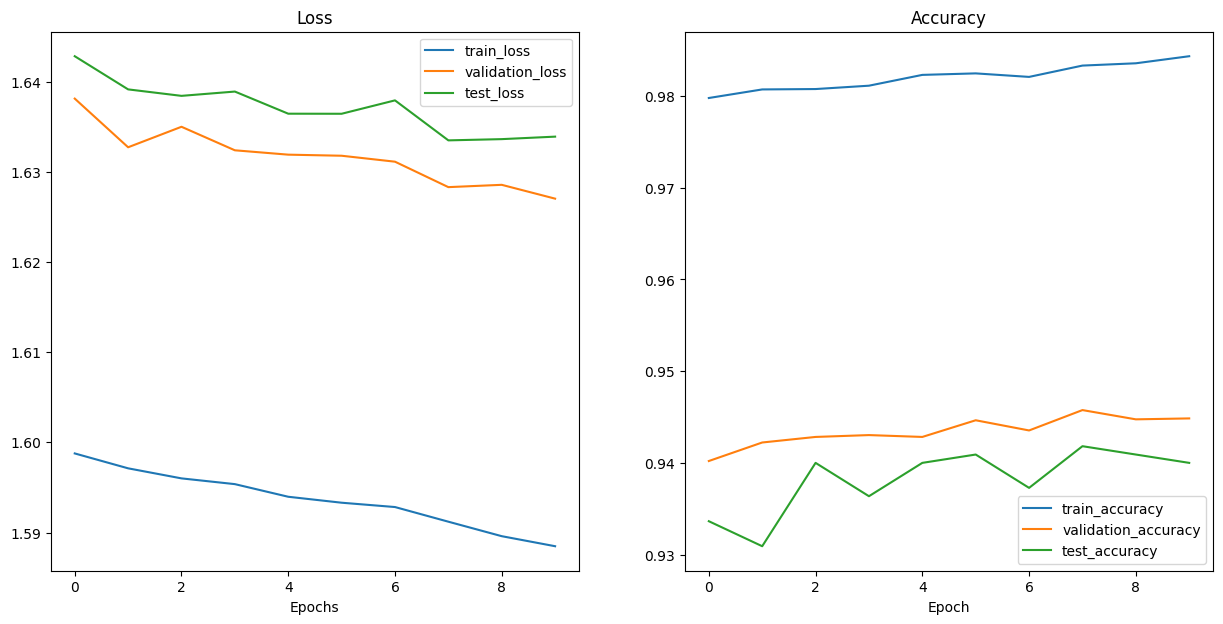

In [ ]:
plot_loss_curves(model_0_results)

In [ ]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'validation_loss', 'validation_acc', 'test_loss', 'test_acc'])

In [ ]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")#

mlxtend version: 0.22.0


In [ ]:
#Import tqdm.auto
from tqdm.auto import tqdm

#Make predictions with trained model
y_preds = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    #Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    #Do the forward pass
    X = X.permute(0, 2, 1)
    y_logit = model_0(X)
    #Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    #Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())

#print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

Making predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

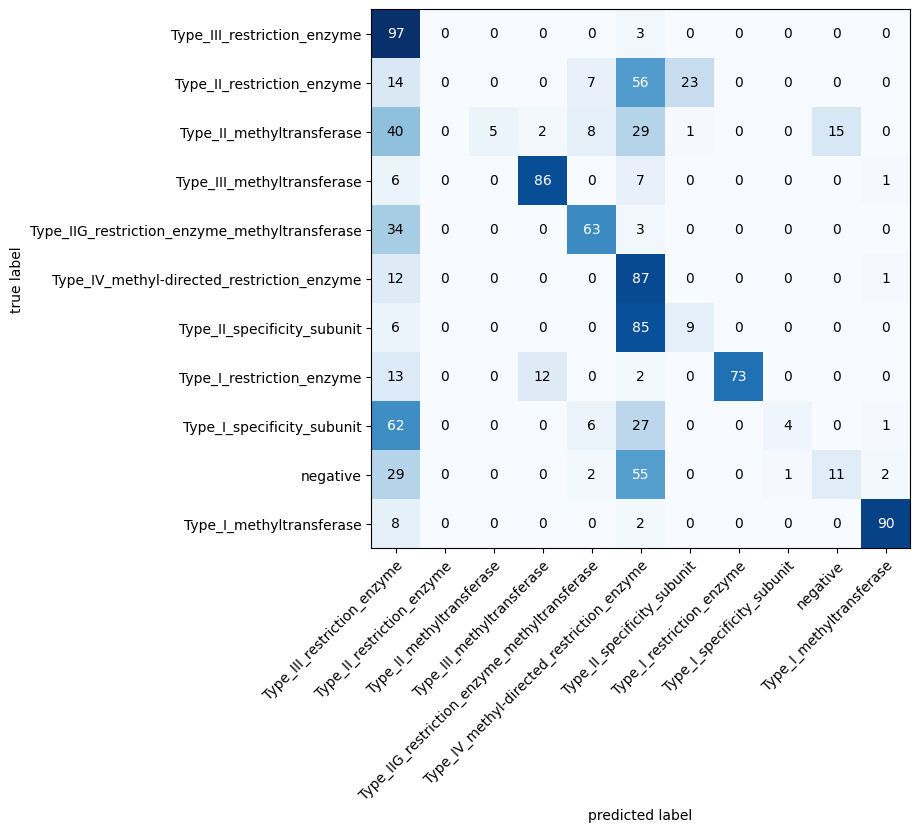

In [ ]:
from torchmetrics import ConfusionMatrix
from tqdm.auto import tqdm
from mlxtend.plotting import plot_confusion_matrix


# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_dict), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.tensor(test_data.labels))  # use .labels instead of .targets

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_dict, # turn the row and column labels into class names
    figsize=(10, 7)
)



In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
# Assuming "model" is your trained model, "test_loader" is your test data loader

model_0.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for data, labels in test_dataloader:
        data, labels = data.to(device), labels.to(device)
        data = data.permute(0, 2, 1)
        outputs = model_0(data)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

print(classification_report(true_labels, predicted_labels))


              precision    recall  f1-score   support

           0       0.20      0.97      0.33       100
           1       0.00      0.00      0.00       100
           2       1.00      0.04      0.08       100
           3       0.91      0.84      0.87       100
           4       0.75      0.44      0.55       100
           5       0.25      0.86      0.39       100
           6       0.00      0.00      0.00       100
           7       1.00      0.69      0.82       100
           8       1.00      0.02      0.04       100
           9       0.00      0.00      0.00       100
          10       1.00      0.35      0.52       100

    accuracy                           0.38      1100
   macro avg       0.55      0.38      0.33      1100
weighted avg       0.55      0.38      0.33      1100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
